# Task Description

## Requirements

Please use the data in  
Sep/2018 or **Nov/2018**  
and compare with data in  
**Mar/2019**  
for the following platforms in the deployment time period.

**Not sure if we have eliminated the early arrivals in the previous analysis.**

Dwell Time Calculation Method:  
* IF Actual Arrival < Planned Arrival,  Dwell = Dwell_Depart_Calc_Time – Planned Arrival
* IF Actual arrival > Planned Arrival, Dwell = Dwell_Depart_Calc_Time – Dwell_Arrival_Calc_Time

OCP-enhanced dwell management

| Station        | Platform | Deployment         | Year (Quarter) commenced |
|----------------|----------|--------------------|--------------------------|
| Wolli Creek    | 1        | 07:00 to 09:00 hrs | Early 2019               |
| International  | 1        | 07:00 to 09:00 hrs | Early 2019               |
| Domestic       | 1        | 07:00 to 09:00 hrs | Early 2019               |
| Mascot         | 1        | 07:00 to 09:00 hrs | Early 2019               |
| Green Square   | 1        | 07:00 to 09:00 hrs | Early 2019               |
| Chatswood (AM) | 1        | 06:30 to 09:00 hrs | Q2 2019 (15 Apr)         |

## Results

The results are summerized as follows.

**Sep2018 VS. Mar2019**

Num Significant Increase 2  
Num Significant Decrease 2  
Num Not Significant 2  
==========Inc_Platform==========  
['CWD1', 'WCI1']  
==========Dec_Platform==========    
['GQU1', 'MCO1']  
==========Not_Platform==========  
['SDT1', 'SIT1']  

**Nov/2018 VS. Mar/2019**

Num Significant Increase 2  
Num Significant Decrease 1  
Num Not Significant 3  
==========Inc_Platform==========  
['CWD1', 'WCI1']  
==========Dec_Platform==========  
['MCO1']  
==========Not_Platform==========  
['GQU1', 'SDT1', 'SIT1']  

**Nov/2018 VS. Nov/2019**

Num Significant Increase 1  
Num Significant Decrease 4  
Num Not Significant 1  
==========Inc_Platform==========  
['CWD1']  
==========Dec_Platform==========  
['GQU1', 'MCO1', 'SDT1', 'WCI1']  
==========Not_Platform==========  
['SIT1']

# Initiliazation

## Load Package

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## Utility Functions

In [11]:
# station_name_union_list = np.intersect1d(
#     data1['actual_arrival_platform'.upper()].unique(),
#     data2['actual_arrival_platform'.upper()].unique())
station_name_union_list = [
    'GQU1', 'GQU2', 'WCI1', 'WCI2', 'SIT1', 'SIT2', 'SDT1', 'SDT2', 'MCO1',
    'MCO2', 'CWD1', 'CWD4'
]


def perform_analysis(data1, data2):

    inc_significant_station = []
    dec_significant_station = []
    not_significant_station = []

    for station_name in np.sort(station_name_union_list):
        print()
        print('Platform Name', station_name)
        data1_by_station = data1.loc[data1.ACTUAL_ARRIVAL_PLATFORM ==
                                     station_name]
        data2_by_station = data2.loc[data2.ACTUAL_ARRIVAL_PLATFORM ==
                                     station_name]

        earl_idx = data1_by_station['tls_actual_arrival_time'.upper(
        )] < data1_by_station['tps_planned_arrival_time'.upper()]
        late_idx = data1_by_station['tls_actual_arrival_time'.upper(
        )] >= data1_by_station['tps_planned_arrival_time'.upper()]

        dwell_time_apr_earl = (
            data1_by_station.loc[earl_idx, 'dwell_depart_calc_time'.upper()] -
            data1_by_station.loc[earl_idx, 'tps_planned_arrival_time'.upper()]
        ).dt.total_seconds()
        negativ_idx = dwell_time_apr_earl < 0
        dwell_time_apr_earl[negativ_idx] = 30

        dwell_time_apr_late = (
            data1_by_station.loc[late_idx, 'dwell_depart_calc_time'.upper()] -
            data1_by_station.loc[late_idx, 'dwell_arrival_calc_time'.upper()]
        ).dt.total_seconds()
        negativ_idx = dwell_time_apr_late < 0
        dwell_time_apr_late[negativ_idx] = 30

        dwell_sec_apr = pd.concat([dwell_time_apr_earl, dwell_time_apr_late],
                                  axis=0)

        earl_idx = data2_by_station['tls_actual_arrival_time'.upper(
        )] < data2_by_station['tps_planned_arrival_time'.upper()]
        late_idx = data2_by_station['tls_actual_arrival_time'.upper(
        )] >= data2_by_station['tps_planned_arrival_time'.upper()]

        dwell_time_nov_earl = (
            data2_by_station.loc[earl_idx, 'dwell_depart_calc_time'.upper()] -
            data2_by_station.loc[earl_idx, 'tps_planned_arrival_time'.upper()]
        ).dt.total_seconds()
        negativ_idx = dwell_time_nov_earl < 0
        dwell_time_nov_earl[negativ_idx] = 30

        dwell_time_nov_late = (
            data2_by_station.loc[late_idx, 'dwell_depart_calc_time'.upper()] -
            data2_by_station.loc[late_idx, 'dwell_arrival_calc_time'.upper()]
        ).dt.total_seconds()
        negativ_idx = dwell_time_nov_late < 0
        dwell_time_nov_late[negativ_idx] = 30

        dwell_sec_nov = pd.concat([dwell_time_nov_earl, dwell_time_nov_late],
                                  axis=0)

        dwell_sec_apr = dwell_sec_apr.loc[dwell_sec_apr != 0.0]
        dwell_sec_apr = dwell_sec_apr.loc[~dwell_sec_apr.isnull()]
        dwell_sec_nov = dwell_sec_nov.loc[dwell_sec_nov != 0.0]
        dwell_sec_nov = dwell_sec_nov.loc[~dwell_sec_nov.isnull()]

        max_waiting_sec = 1200
        num_sample = np.min([dwell_sec_apr.shape[0], dwell_sec_nov.shape[0]])
        num_bins = 20
        dwell_sec_apr = dwell_sec_apr.loc[dwell_sec_apr < max_waiting_sec]
        dwell_sec_nov = dwell_sec_nov.loc[dwell_sec_nov < max_waiting_sec]

        random_idx_apr = np.random.permutation(
            dwell_sec_apr.shape[0])[:num_sample]
        random_idx_nov = np.random.permutation(
            dwell_sec_nov.shape[0])[:num_sample]

        if dwell_sec_apr.shape[0] == 0 or dwell_sec_nov.shape[0] == 0:
            pass
        else:
            h, p = stats.ks_2samp(dwell_sec_apr.values[random_idx_apr],
                                  dwell_sec_nov.values[random_idx_nov])

            print('Dwell time selected by:')
            print('    Max waiting second', max_waiting_sec)
            print('    Sample size', num_sample)
            # print()
            print('=' * 15, 'Statistics'.center(10), '=' * 15)
            print(ledgen1 + ' dwell median in (sec)',
                  dwell_sec_apr.iloc[random_idx_apr].median())
            print(ledgen2 + ' dwell median in (sec)',
                  dwell_sec_nov.iloc[random_idx_nov].median())
            print('KS two-sample test pValue', p)
            if p < 0.05:
                if dwell_sec_nov.iloc[random_idx_nov].median(
                ) > dwell_sec_apr.iloc[random_idx_apr].median():
                    inc_significant_station.append(station_name)
                    print('Dwell Time Increase IS Signficiant')
                else:
                    dec_significant_station.append(station_name)
                    print('Dwell Time Decrease IS Signficiant')
            else:
                not_significant_station.append(station_name)
                if dwell_sec_nov.iloc[random_idx_nov].median(
                ) > dwell_sec_apr.iloc[random_idx_apr].median():
                    print('Dwell Time Increase NOT Signficiant')
                else:
                    print('Dwell Time Decrease NOT Signficiant')

            dwell_sec_apr.iloc[random_idx_apr].hist(bins=num_bins,
                                                    density=True,
                                                    alpha=0.5)
            dwell_sec_nov.iloc[random_idx_nov].hist(bins=num_bins,
                                                    density=True,
                                                    alpha=0.5)
            plt.legend(
                [ledgen1 + ' ' + station_name, ledgen2 + ' ' + station_name])
            plt.title(
                station_name + ', ' + ledgen1 + ' - ' + ledgen2 +
                ' Dwell Time Histogram by Density\n' + 'MedianDiff ' +
                '{:.2f}'.format(dwell_sec_apr.iloc[random_idx_apr].median() -
                                dwell_sec_nov.iloc[random_idx_nov].median()))
            plt.xlabel('Dwell Time (s)')
            plt.ylabel('Density (%)')
            plt.show()

            dwell_sec_apr_sorted = dwell_sec_apr.iloc[
                random_idx_apr].sort_values().reset_index(drop=True)
            dwell_sec_apr_sorted.plot()
            dwell_sec_nov_sorted = dwell_sec_nov.iloc[
                random_idx_nov].sort_values().reset_index(drop=True)
            dwell_sec_nov_sorted.plot()
            plt.legend(
                [ledgen1 + ' ' + station_name, ledgen2 + ' ' + station_name])
            plt.title(ledgen1 + ' - ' + ledgen2)
            plt.xlabel('Order')
            plt.ylabel('Dwell Time (s)')
            plt.show()

    print()
    print()
    print('Num Significant Increase', len(inc_significant_station))
    print('Num Significant Decrease', len(dec_significant_station))
    print('Num Not Significant', len(not_significant_station))
    print('=' * 10 + 'Inc_Platform'.center(10) + '=' * 10)
    print(inc_significant_station)
    print('=' * 10 + 'Dec_Platform'.center(10) + '=' * 10)
    print(dec_significant_station)
    print('=' * 10 + 'Not_Platform'.center(10) + '=' * 10)
    print(not_significant_station)


def data_preprocessing(data1, data2):

    data1 = data1.loc[data1['PERIODS'] == 'AM Peak']
    data2 = data2.loc[data2['PERIODS'] == 'AM Peak']

    data1['tps_planned_arrival_time'.upper()] = pd.to_datetime(
        data1['tps_planned_arrival_time'.upper()])
    data1['dwell_arrival_calc_time'.upper()] = pd.to_datetime(
        data1['dwell_arrival_calc_time'.upper()])
    data1['dwell_depart_calc_time'.upper()] = pd.to_datetime(
        data1['dwell_depart_calc_time'.upper()])
    data1['tls_actual_arrival_time'.upper()] = pd.to_datetime(
        data1['tls_actual_arrival_time'.upper()])

    data2['tps_planned_arrival_time'.upper()] = pd.to_datetime(
        data2['tps_planned_arrival_time'.upper()])
    data2['dwell_arrival_calc_time'.upper()] = pd.to_datetime(
        data2['dwell_arrival_calc_time'.upper()])
    data2['dwell_depart_calc_time'.upper()] = pd.to_datetime(
        data2['dwell_depart_calc_time'.upper()])
    data2['tls_actual_arrival_time'.upper()] = pd.to_datetime(
        data2['tls_actual_arrival_time'.upper()])

    data1_up_idx = (data1['tps_planned_arrival_time'.upper()].dt.hour >= 7) & (
        data1['tps_planned_arrival_time'.upper()].dt.hour <= 8)
    data2_up_idx = (data2['tps_planned_arrival_time'.upper()].dt.hour >= 7) & (
        data2['tps_planned_arrival_time'.upper()].dt.hour <= 8)

    data1 = data1.loc[data1_up_idx]
    data2 = data2.loc[data2_up_idx]
    return data1, data2

# ===== Nov2018 VS. Mar2019 ===== #

/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do


Platform Name CWD1
Dwell time selected by:
    Max waiting second 1200
    Sample size 384
=============== Statistics ===============
Nov 2018 dwell median in (sec) 37.0
Mar 2019 dwell median in (sec) 43.0
KS two-sample test pValue 2.993259728688982e-09
Dwell Time Increase IS Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.


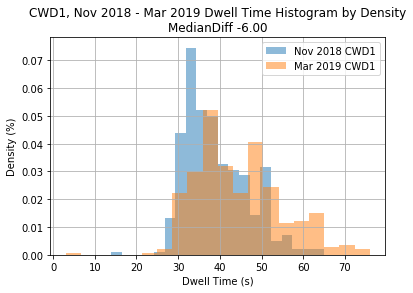

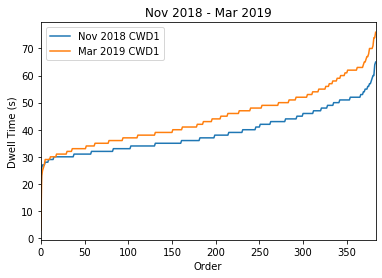


Platform Name CWD4

Platform Name GQU1
Dwell time selected by:
    Max waiting second 1200
    Sample size 100
=============== Statistics ===============
Nov 2018 dwell median in (sec) 53.5
Mar 2019 dwell median in (sec) 42.0
KS two-sample test pValue 0.009878183186176536
Dwell Time Decrease IS Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

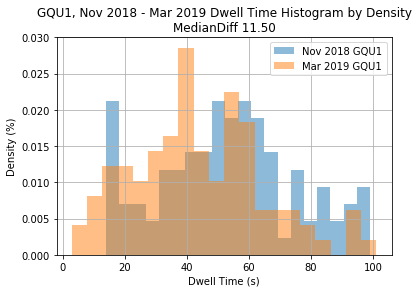

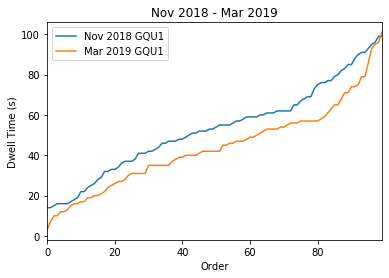


Platform Name GQU2

Platform Name MCO1
Dwell time selected by:
    Max waiting second 1200
    Sample size 100
=============== Statistics ===============
Nov 2018 dwell median in (sec) 47.5
Mar 2019 dwell median in (sec) 40.0
KS two-sample test pValue 0.024055802841094577
Dwell Time Decrease IS Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

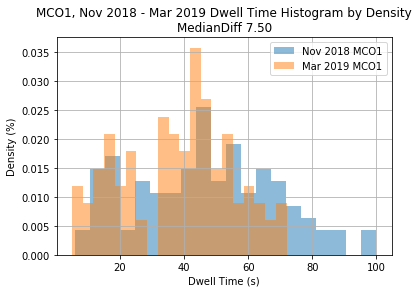

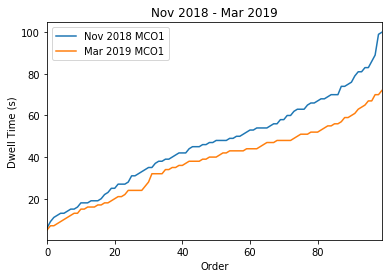


Platform Name MCO2

Platform Name SDT1
Dwell time selected by:
    Max waiting second 1200
    Sample size 100
=============== Statistics ===============
Nov 2018 dwell median in (sec) 36.5
Mar 2019 dwell median in (sec) 31.000000000000004
KS two-sample test pValue 0.36818778606286096
Dwell Time Decrease NOT Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

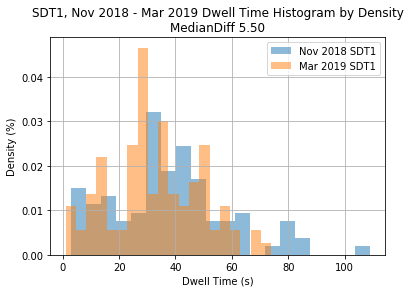

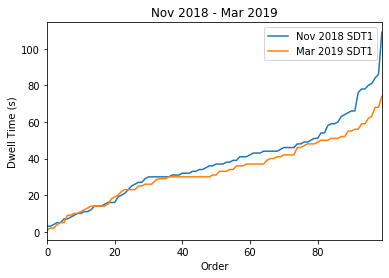


Platform Name SDT2

Platform Name SIT1
Dwell time selected by:
    Max waiting second 1200
    Sample size 84
=============== Statistics ===============
Nov 2018 dwell median in (sec) 29.000000000000004
Mar 2019 dwell median in (sec) 32.0
KS two-sample test pValue 0.13752104079321353
Dwell Time Increase NOT Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

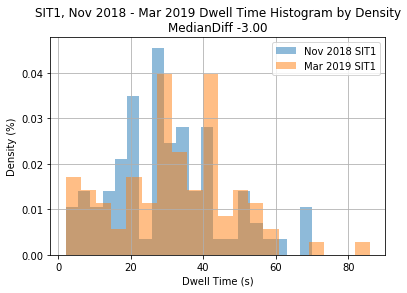

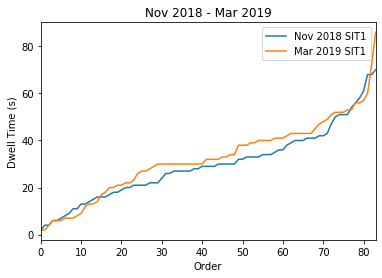


Platform Name SIT2

Platform Name WCI1
Dwell time selected by:
    Max waiting second 1200
    Sample size 83
=============== Statistics ===============
Nov 2018 dwell median in (sec) 30.0
Mar 2019 dwell median in (sec) 32.0
KS two-sample test pValue 0.009606102301959966
Dwell Time Increase IS Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

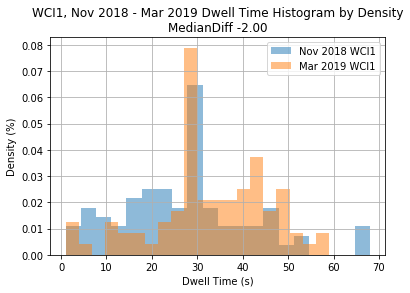

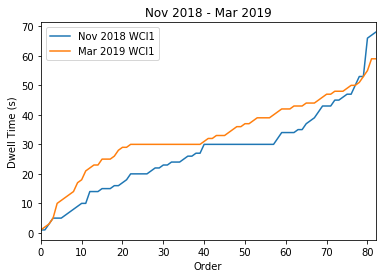


Platform Name WCI2


Num Significant Increase 2
Num Significant Decrease 2
Num Not Significant 2
==========Inc_Platform==========
['CWD1', 'WCI1']
==========Dec_Platform==========
['GQU1', 'MCO1']
==========Not_Platform==========
['SDT1', 'SIT1']


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

In [12]:
# ===== Nov2018 VS. Mar2019 ===== #
ledgen1 = 'Nov 2018'
ledgen2 = 'Mar 2019'
data1 = pd.read_csv('Data/2018-11.csv')
data2 = pd.read_csv('Data/Dart/Dart_Mar.csv')

data1, data2 = data_preprocessing(data1, data2)
perform_analysis(data1, data2)

# ===== Sep2018 VS. Mar2019 ===== #

/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (88,89) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-


Platform Name CWD1
Dwell time selected by:
    Max waiting second 1200
    Sample size 301
=============== Statistics ===============
Sep 2018 dwell median in (sec) 36.0
Mar 2019 dwell median in (sec) 43.0
KS two-sample test pValue 1.0347150844885526e-15
Dwell Time Increase IS Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.


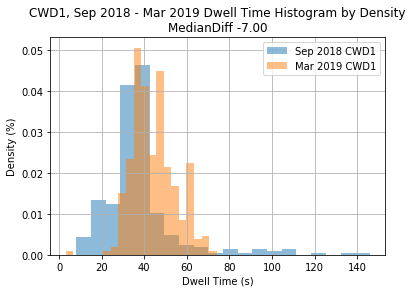

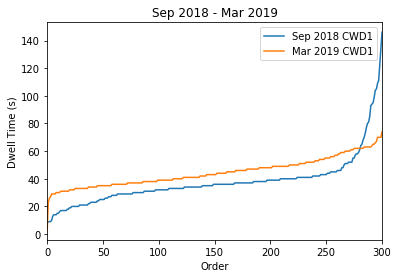


Platform Name CWD4

Platform Name GQU1
Dwell time selected by:
    Max waiting second 1200
    Sample size 100
=============== Statistics ===============
Sep 2018 dwell median in (sec) 49.0
Mar 2019 dwell median in (sec) 42.0
KS two-sample test pValue 0.015577131622877688
Dwell Time Decrease IS Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

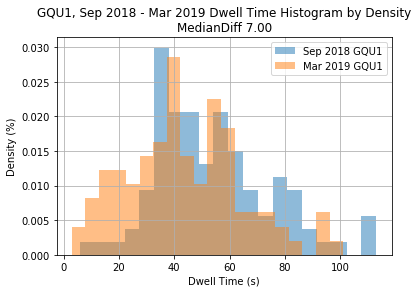

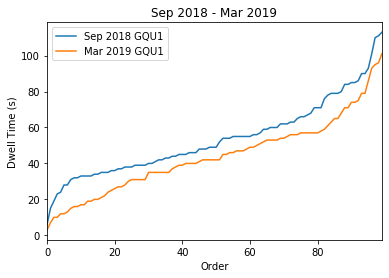


Platform Name GQU2

Platform Name MCO1
Dwell time selected by:
    Max waiting second 1200
    Sample size 100
=============== Statistics ===============
Sep 2018 dwell median in (sec) 51.5
Mar 2019 dwell median in (sec) 40.0
KS two-sample test pValue 3.211428734211389e-05
Dwell Time Decrease IS Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

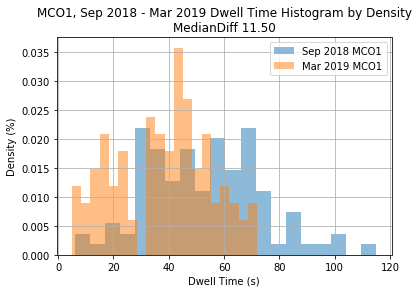

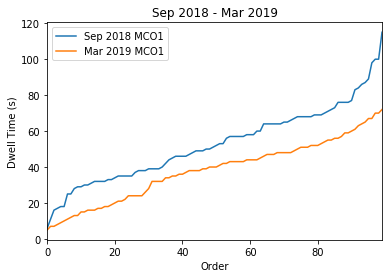


Platform Name MCO2

Platform Name SDT1
Dwell time selected by:
    Max waiting second 1200
    Sample size 100
=============== Statistics ===============
Sep 2018 dwell median in (sec) 38.0
Mar 2019 dwell median in (sec) 31.000000000000004
KS two-sample test pValue 0.11119526053829192
Dwell Time Decrease NOT Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

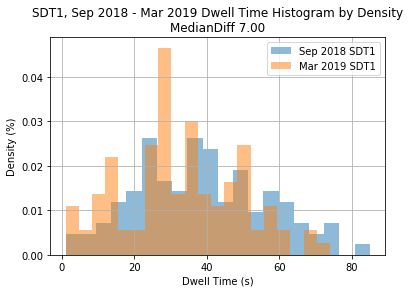

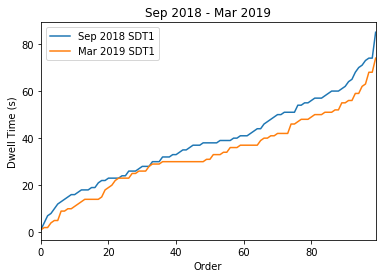


Platform Name SDT2

Platform Name SIT1
Dwell time selected by:
    Max waiting second 1200
    Sample size 84
=============== Statistics ===============
Sep 2018 dwell median in (sec) 31.0
Mar 2019 dwell median in (sec) 32.0
KS two-sample test pValue 0.3597762347141508
Dwell Time Increase NOT Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

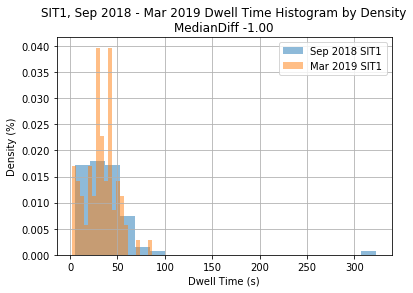

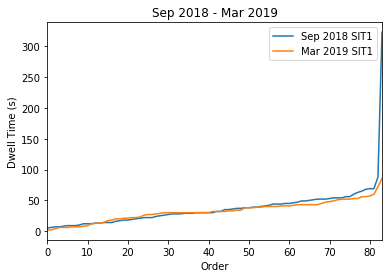


Platform Name SIT2

Platform Name WCI1
Dwell time selected by:
    Max waiting second 1200
    Sample size 83
=============== Statistics ===============
Sep 2018 dwell median in (sec) 30.0
Mar 2019 dwell median in (sec) 32.0
KS two-sample test pValue 0.04004808403829575
Dwell Time Increase IS Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

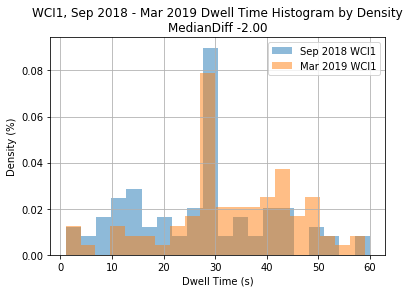

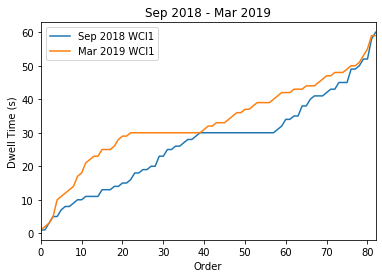


Platform Name WCI2


Num Significant Increase 2
Num Significant Decrease 2
Num Not Significant 2
==========Inc_Platform==========
['CWD1', 'WCI1']
==========Dec_Platform==========
['GQU1', 'MCO1']
==========Not_Platform==========
['SDT1', 'SIT1']


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

In [15]:
# ===== Sep2018 VS. Mar2019 ===== #
ledgen1 = 'Sep 2018'
ledgen2 = 'Mar 2019'
data1 = pd.read_csv('Data/2018-09.csv')
data2 = pd.read_csv('Data/Dart/Dart_Mar.csv')

data1, data2 = data_preprocessing(data1, data2)
perform_analysis(data1, data2)

# ===== Nov2018 VS. Nov2019 =====

/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (88,89) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-


Platform Name CWD1
Dwell time selected by:
    Max waiting second 1200
    Sample size 414
=============== Statistics ===============
Nov 2018 dwell median in (sec) 37.0
Nov 2019 dwell median in (sec) 48.0
KS two-sample test pValue 1.8674628998954472e-46
Dwell Time Increase IS Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.


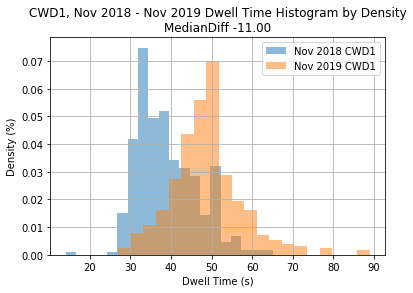

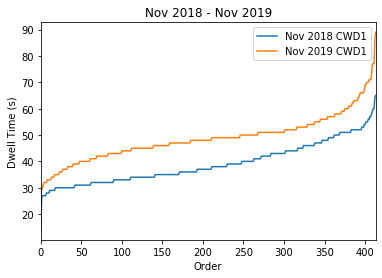


Platform Name CWD4

Platform Name GQU1
Dwell time selected by:
    Max waiting second 1200
    Sample size 117
=============== Statistics ===============
Nov 2018 dwell median in (sec) 52.0
Nov 2019 dwell median in (sec) 43.0
KS two-sample test pValue 0.006048763280613777
Dwell Time Decrease IS Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

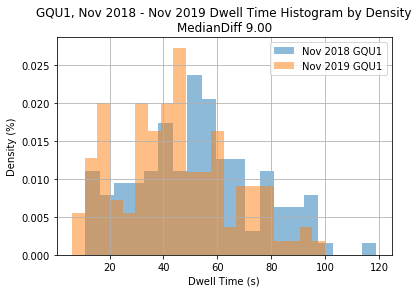

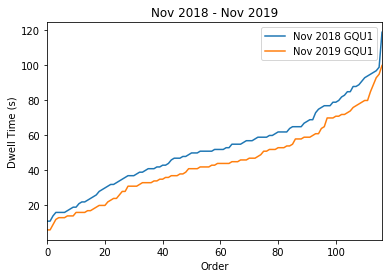


Platform Name GQU2

Platform Name MCO1
Dwell time selected by:
    Max waiting second 1200
    Sample size 117
=============== Statistics ===============
Nov 2018 dwell median in (sec) 46.0
Nov 2019 dwell median in (sec) 39.0
KS two-sample test pValue 0.06536639171199558
Dwell Time Decrease NOT Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

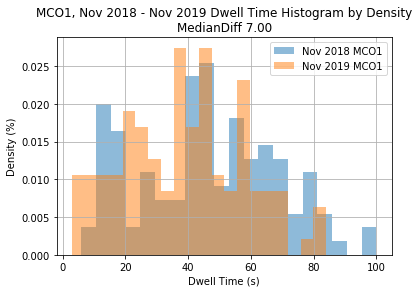

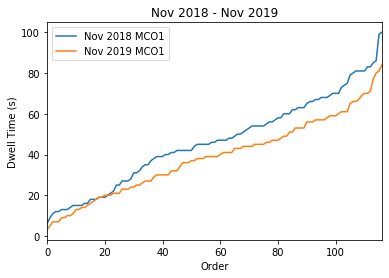


Platform Name MCO2

Platform Name SDT1
Dwell time selected by:
    Max waiting second 1200
    Sample size 116
=============== Statistics ===============
Nov 2018 dwell median in (sec) 36.5
Nov 2019 dwell median in (sec) 30.0
KS two-sample test pValue 0.008972619078284746
Dwell Time Decrease IS Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

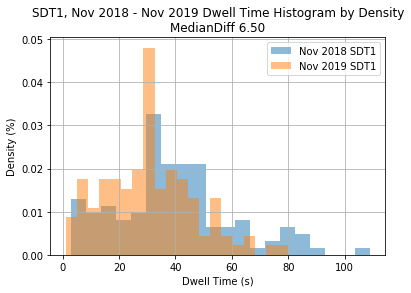

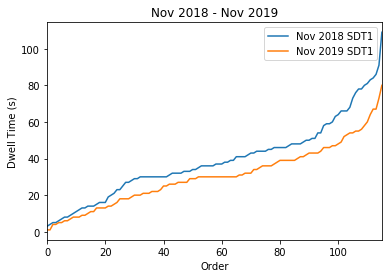


Platform Name SDT2

Platform Name SIT1
Dwell time selected by:
    Max waiting second 1200
    Sample size 96
=============== Statistics ===============
Nov 2018 dwell median in (sec) 30.0
Nov 2019 dwell median in (sec) 30.0
KS two-sample test pValue 0.6776467663158616
Dwell Time Decrease NOT Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

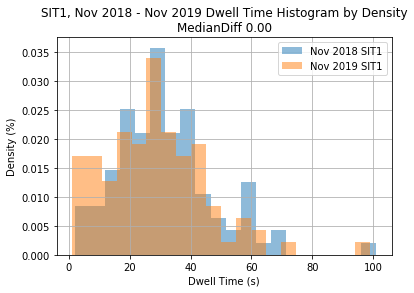

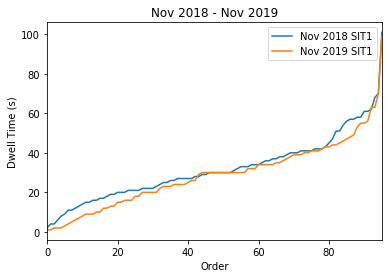


Platform Name SIT2

Platform Name WCI1
Dwell time selected by:
    Max waiting second 1200
    Sample size 94
=============== Statistics ===============
Nov 2018 dwell median in (sec) 30.0
Nov 2019 dwell median in (sec) 30.0
KS two-sample test pValue 0.4297617819851761
Dwell Time Decrease NOT Signficiant


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

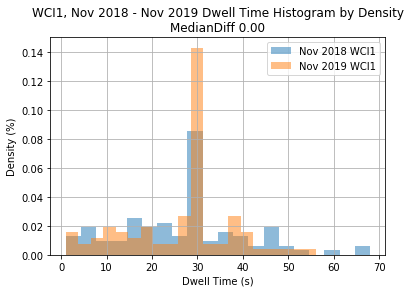

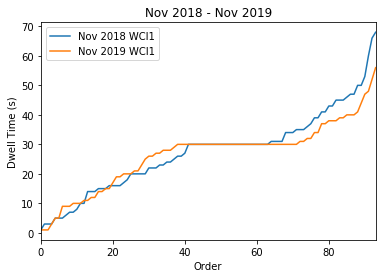


Platform Name WCI2


Num Significant Increase 1
Num Significant Decrease 2
Num Not Significant 3
==========Inc_Platform==========
['CWD1']
==========Dec_Platform==========
['GQU1', 'SDT1']
==========Not_Platform==========
['MCO1', 'SIT1', 'WCI1']


/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipy

In [16]:
# ===== Nov2018 VS. Nov2019 ===== #
ledgen1 = 'Nov 2018'
ledgen2 = 'Nov 2019'
data1 = pd.read_csv('Data/2018-11.csv')
data2 = pd.read_csv('Data/Dart/Dart_Nov.csv')

data1, data2 = data_preprocessing(data1, data2)
perform_analysis(data1, data2)

# Negative Value Explore

In [4]:
station_name_union_list = [
    'MCO1',
    #'SDT1'
]

# ===== Nov2018 VS. Nov2019 ===== #
ledgen1 = 'Nov 2018'
ledgen2 = 'Nov 2019'
data1 = pd.read_csv('Data/2018-11.csv')
data2 = pd.read_csv('Data/Dart/Dart_Mar.csv')

data1, data2 = data_preprocessing(data1, data2)

/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (88,89) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/ipykernel_launcher.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [5]:
data_explore = pd.read_csv('Data/Dart/Dart_Nov.csv')
time_feats_list = [
    'tps_planned_arrival_time'.upper(), 'tps_planned_departure_time'.upper(),
    'tls_actual_arrival_time'.upper(), 'tls_actual_departure_time'.upper(),
    'dwell_arrival_calc_time'.upper(), 'dwell_depart_calc_time'.upper()
]
data_explore = data_explore[:1000]

In [6]:
for feat in time_feats_list:
    data_explore[feat] = pd.to_datetime(data_explore[feat])

In [7]:
data_explore[time_feats_list].to_csv('TimeFeatures', index=False)

In [17]:
negativ_idx = (
    data_explore['dwell_depart_calc_time'.upper()] -
    data_explore['dwell_arrival_calc_time'.upper()]).dt.total_seconds() < 0
negativ_idx

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool

In [18]:
negativ_idx.sum()

0

In [9]:
data_explore.loc[negativ_idx].to_csv('ItemsWithNegativDwell.csv', index=False)